# Fake Review Detection

In [24]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sqlite3
import re
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Load Data

In [48]:
conn = sqlite3.connect('../data/yelpResData.db')
conn.text_factory = lambda b: b.decode(errors = 'ignore')

In [5]:
# check table names in the database
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

review
restaurant
reviewer


#### Load restaurant dataset

In [49]:
# load restaurant table to df
res = pd.read_sql("select * from restaurant;", conn)

In [57]:
res.categories.value_counts()[:3]

Restaurants, Mexican, METADATA                                  7384
Add, METADATA                                                   6442
Event Planning & Services, Hotels, Hotels & Travel, METADATA    5453
Name: categories, dtype: int64

In [58]:
res = res[res.categories.str.contains('Restaurants')]

In [59]:
# take selection columns
columns = ['restaurantID', 'name', 'rating']
res = res[columns]
res = res.rename(columns={'name':'restaurant_name'})

#### Load review dataset

In [60]:
# load review table to df
review = pd.read_sql("select * from review;", conn)
review.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'rating',
       'usefulCount', 'coolCount', 'funnyCount', 'flagged', 'restaurantID'],
      dtype='object')

In [61]:
# check the classes in flagged column
review.flagged.value_counts()

NR    402774
YR    318678
N      58716
Y       8303
Name: flagged, dtype: int64

There are 4 classes in the review dataframe. Y and N classes are not filtered by the Yelp fake review detection engine, less reliable labelling. Since we have about 700k reviews left (large enough) and the N and Y classes combined makes only 8.5% of the data, we decided to remove them, only keeping NR and YR classes.
- NR: True review
- YR: Fake review

In [62]:
review = review[(review.flagged != 'Y') & (review.flagged != 'N')]
review.reset_index(drop=True,inplace=True)

In [64]:
# checking if there are duplicated reviews
if (review.shape[0] == review.reviewID.nunique()):
    print('there are no duplicated reviews')
else:
    print('Duplicated reviews are')
    mask = review.duplicated(subset='reviewID', keep = False)
    review[mask]

there are no duplicated reviews


In [65]:
# clean the date column in review
mask = review.date.str.contains('Update')
ok_date = review[~mask]
notok_date = review[mask]
notok_date['date'] = notok_date['date'].apply(lambda x: str(x).split()[2])
review = pd.concat([ok_date, notok_date])

In [66]:
# convert date to datetime
review.date = pd.to_datetime(review.date)

#### Load reviewer dataset

In [67]:
# load reviewer table to df
reviewer = pd.read_sql("select * from reviewer;", conn)
reviewer.columns

Index(['reviewerID', 'name', 'location', 'yelpJoinDate', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

In [68]:
# repeated columns in review and reviewer
review_reviewer_intersect = set(review.columns).intersection(set(reviewer.columns))
review_res_intersect = set(review.columns).intersection(set(res.columns))

print('review_reviewer_intersect: {}'.format(review_reviewer_intersect))
print('review_res_intersect: {}'.format(review_res_intersect))

review_reviewer_intersect: {'funnyCount', 'reviewerID', 'coolCount', 'usefulCount'}
review_res_intersect: {'restaurantID', 'rating'}


Both review and reviewer df have columns coolCount, funnyCount, usefulCount. We need to differentiate them. Similarly, review and restaurant both have rating columns

In [131]:
review = review.rename(columns={'coolCount':'review_coolCount', 'funnyCount':'review_funnyCount', 
                                'usefulCount':'review_usefulCount', 'rating': 'review_rating'})
reviewer = reviewer.rename(columns={'name':'reviewer_name'})

In [70]:
# the yelpJoinDate is in format 'June 2019', change it to datetime object
reviewer['yelpJoinDate'] = reviewer['yelpJoinDate'].apply(lambda x: datetime.strftime(datetime.strptime(x, '%B %Y'), '01/%m/%Y'))
reviewer['yelpJoinDate'] = pd.to_datetime(reviewer['yelpJoinDate'])
reviewer['yelpJoinDate'].values[0]

numpy.datetime64('2009-01-10T00:00:00.000000000')

In [71]:
# merge the 3 tables
df_merged = review.merge(reviewer, on='reviewerID', how='inner')
df = df_merged.merge(res, on='restaurantID', how='inner')
print('Final df columns:')
print(df.columns.to_list())
df.head()

Final df columns:
['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating', 'review_usefulCount', 'review_coolCount', 'review_funnyCount', 'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount', 'complimentCount', 'tipCount', 'fanCount', 'restaurant_name', 'rating']


,date,reviewID,reviewerID,reviewContent,review_rating,review_usefulCount,review_coolCount,review_funnyCount,flagged,restaurantID,...,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount,restaurant_name,rating
0,2012-09-25,xvdJntJlo01tHu83-vXiRw,bNYesZ944s6IJVowOnB0iA,Good choice by our Chicago friends for our fin...,4,0,0,0,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,48,5,41,5,5,2,0,1,Slurping Turtle,3.5
1,2012-06-23,Z4oAUd6mIOhxxDsle3trPA,BSh3h1J4mdSmEsb8FFdf0Q,"I'm not a Takashi fan, so I was a bit hesitant...",4,0,0,0,YR,KU_Ze0TpR2HgKG2OpTh2NA,...,116,2,93,16,19,10,0,2,Slurping Turtle,3.5
2,2012-10-10,71c7BDude0l5tNjtxRZzMg,XVvbDeYn5Dk-MteNHwjC7Q,I should have read the the 3 stars and below r...,2,0,0,0,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,14,1,5,1,3,0,4,1,Slurping Turtle,3.5
3,2011-12-15,Vrzm2xmm2aBqBRqs3yK9Zw,om5ZiponkpRqUNa3pVPiRg,It must be called slurping turtle because thei...,3,8,3,4,YR,KU_Ze0TpR2HgKG2OpTh2NA,...,2063,347,12660,9617,6682,6948,605,503,Slurping Turtle,3.5
4,2012-09-07,coKi6jCbVd4qSUpoE5_0iA,LZt80LbsfQ9kOz96H7c1bA,I'm surprised this place is getting so many ne...,4,2,2,1,NR,KU_Ze0TpR2HgKG2OpTh2NA,...,132,0,154,84,22,24,3,7,Slurping Turtle,3.5


In [190]:
# easy loading next time
# df.to_pickle('../data/merged_df.pkl')
df = pd.read_pickle('../data/merged_df.pkl')

In [191]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating'],
      dtype='object')

# EDA
## Overview

In [192]:
df.flagged.value_counts()

YR    223414
NR    187966
Name: flagged, dtype: int64

In [193]:
df.loc[df['flagged'] == 'YR', 'flagged'] = 0
df.loc[df['flagged'] == 'NR', 'flagged'] = 1

In [194]:
real = df[df.flagged == 1]
fake = df[df.flagged == 0]

In [139]:
# check if every review is unique
df.reviewID.nunique() == df.shape[0]

True

In [140]:
# total number of unique reviews
df.shape[0]

411380

In [141]:
# check the number of unique reviewers
df.reviewerID.nunique()

14321

In [142]:
# check the locations
df.location.value_counts()

Chicago, IL             135047
San Francisco, CA        30996
Los Angeles, CA          14517
New York, NY             13549
Boston, MA                5389
                         ...  
Fort Myers Beach, FL         1
Ina, IL                      1
Hammondsport, NY             1
Rosharon, TX                 1
Marquette, MI                1
Name: location, Length: 1361, dtype: int64

In [143]:
# check number of restaurants
df.restaurantID.nunique()

114625

## Review Columns EDA
### Review Date Exploration

In [144]:
df.date.describe()

count                  411380
unique                   2802
top       2009-02-08 00:00:00
freq                      542
first     2004-10-12 00:00:00
last      2012-10-22 00:00:00
Name: date, dtype: object

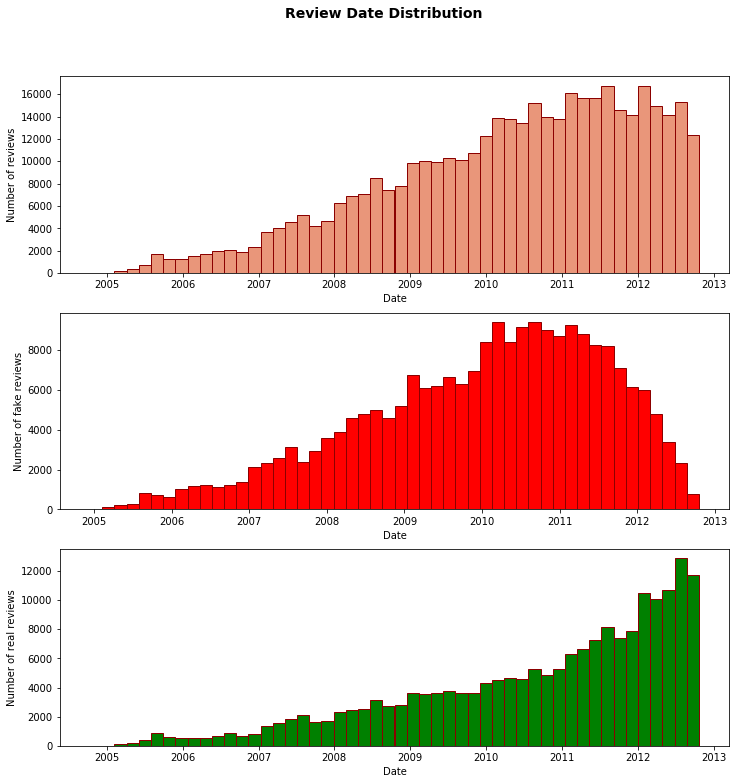

In [145]:
# Prepare the figure
fig = plt.figure( figsize=(12,12) )
title = fig.suptitle("Review Date Distribution", fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.9, wspace=0.3)

# Prepare a subplot
ax = fig.add_subplot(3,1,1) # https://youtu.be/afITiFR6vfw?t=1m53s
ax.set_xlabel("Date")
ax.set_ylabel("Number of reviews")

# Add text into the subplot
freq, bins, patches = ax.hist(df['date'], 
                              bins=50,
                              color='darksalmon', 
                              edgecolor='darkred', linewidth=1.0)

# Prepare a subplot
ax2 = fig.add_subplot(3,1,2) 
ax2.set_ylabel("Number of fake reviews")
ax2.set_xlabel("Date")

# Add text into the subplot
freq, bins, patches = ax2.hist(fake['date'], 
                              bins=50,
                              color='red', 
                              edgecolor='darkred', linewidth=1.0)
# Prepare a subplot
ax3 = fig.add_subplot(3,1,3) 
ax3.set_ylabel("Number of real reviews")
ax3.set_xlabel("Date")

# Add text into the subplot
freq, bins, patches = ax3.hist(real['date'], 
                              bins=50,
                              color='green', 
                              edgecolor='darkred', linewidth=1.0)

In [146]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating'],
      dtype='object')

### Review Rating Exploration

In [147]:
# check review ratings
df.review_rating.value_counts()

4    161943
3     94693
5     92069
2     42179
1     20496
Name: review_rating, dtype: int64

Total review count:  411380
Total fake reviews:  223414
Total real reviews:  187966


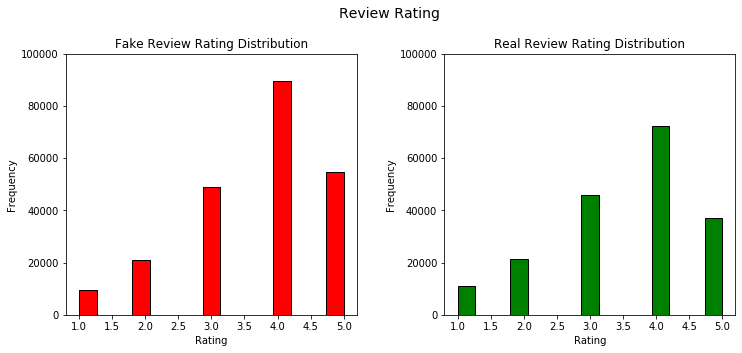

In [148]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Rating", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Rating Distribution")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 100000])
print('Total review count: ', df.shape[0])
print('Total fake reviews: ' ,fake.shape[0])
r_freq, r_bins, r_patches = ax1.hist(fake['review_rating'], color='red', bins=15,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Rating Distribution")
ax2.set_xlabel("Rating")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 100000])
print('Total real reviews: ' ,real.shape[0])
w_freq, w_bins, w_patches = ax2.hist(real['review_rating'], color='green', bins=15,
                                     edgecolor='black', linewidth=1)

In [149]:
ave_all_rating = df.review_rating.mean()
ave_fake_rating = fake.review_rating.mean()
ave_real_rating = real.review_rating.mean()
print('Average rating for all reviews: ', round(ave_all_rating,2))
print('Average rating for fake reviews: ', round(ave_fake_rating,2))
print('Average rating for real reviews: ', round(ave_real_rating,2))

Average rating for all reviews:  3.64
Average rating for fake reviews:  3.71
Average rating for real reviews:  3.55


### Review usefulCount Exploration (includes other counts)

In [150]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating'],
      dtype='object')

Average total reviews useful counts:  1.43
Average fake reviews useful counts:  1.22
Average real reviews useful counts:  1.69


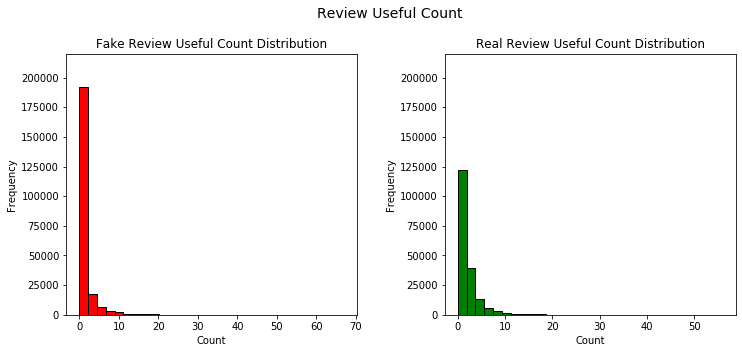

In [151]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Useful Count", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Useful Count Distribution")
ax1.set_xlabel("Count")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 220000])
print('Average total reviews useful counts: ', round(df['review_usefulCount'].mean(),2))
print('Average fake reviews useful counts: ' ,round(fake['review_usefulCount'].mean(),2))
r_freq, r_bins, r_patches = ax1.hist(fake['review_usefulCount'], color='red', bins=30,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Useful Count Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 220000])
print('Average real reviews useful counts: ' ,round(real['review_usefulCount'].mean(),2))
w_freq, w_bins, w_patches = ax2.hist(real['review_usefulCount'], color='green', bins=30,
                                     edgecolor='black', linewidth=1)

Average total reviews Cool counts:  0.95
Average fake reviews Cool counts:  0.85
Average real reviews Cool counts:  1.06


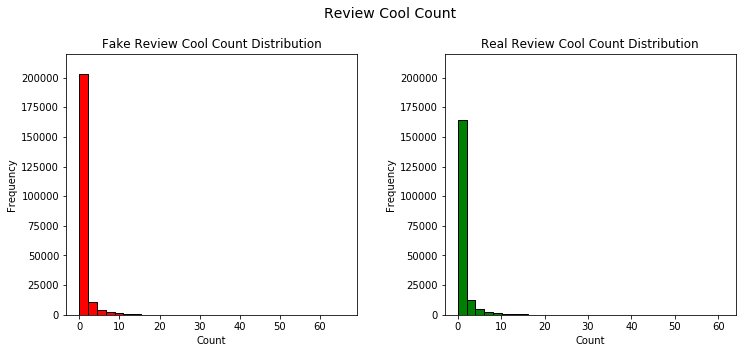

In [152]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Cool Count", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Cool Count Distribution")
ax1.set_xlabel("Count")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 220000])
print('Average total reviews Cool counts: ', round(df['review_coolCount'].mean(),2))
print('Average fake reviews Cool counts: ' ,round(fake['review_coolCount'].mean(),2))
r_freq, r_bins, r_patches = ax1.hist(fake['review_coolCount'], color='red', bins=30,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Cool Count Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 220000])
print('Average real reviews Cool counts: ' ,round(real['review_coolCount'].mean(),2))
w_freq, w_bins, w_patches = ax2.hist(real['review_coolCount'], color='green', bins=30,
                                     edgecolor='black', linewidth=1)

Average total reviews funny counts:  0.77
Average fake reviews funny counts:  0.67
Average real reviews funny counts:  0.89


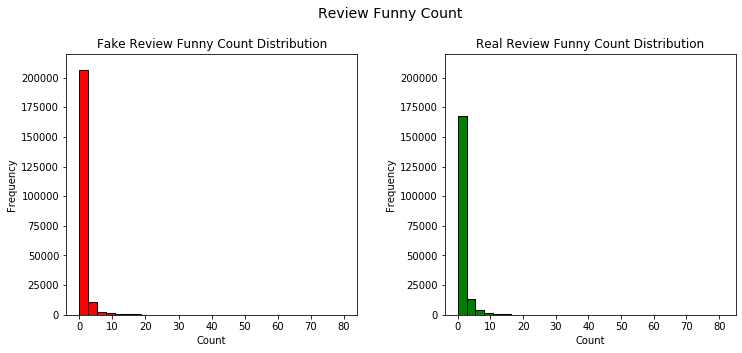

In [153]:
fig = plt.figure(figsize = (12,5))
title = fig.suptitle("Review Funny Count", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2, 1)
ax1.set_title("Fake Review Funny Count Distribution")
ax1.set_xlabel("Count")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 220000])
print('Average total reviews funny counts: ', round(df['review_funnyCount'].mean(),2))
print('Average fake reviews funny counts: ' ,round(fake['review_funnyCount'].mean(),2))
r_freq, r_bins, r_patches = ax1.hist(fake['review_funnyCount'], color='red', bins=30,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,2, 2)
ax2.set_title("Real Review Funny Count Distribution")
ax2.set_xlabel("Count")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 220000])
print('Average real reviews funny counts: ' ,round(real['review_funnyCount'].mean(),2))
w_freq, w_bins, w_patches = ax2.hist(real['review_funnyCount'], color='green', bins=30,
                                     edgecolor='black', linewidth=1)

## Reviewer Columns EDA
### FriendCount

In [155]:
fake.reviewerID.nunique()

13815

In [156]:
real.reviewerID.nunique()

9248

In [157]:
df.reviewerID.nunique()

14321

Fake review ratio:
The number of reviews filtered as fake review / total number of reviews by the reviewer

In [195]:
df.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'review_rating',
       'review_usefulCount', 'review_coolCount', 'review_funnyCount',
       'flagged', 'restaurantID', 'reviewer_name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
       'funnyCount', 'complimentCount', 'tipCount', 'fanCount',
       'restaurant_name', 'rating'],
      dtype='object')

In [201]:
cols = ['reviewerID','reviewer_name', 'location', 'yelpJoinDate',
        'friendCount', 'reviewCount', 'firstCount', 'usefulCount', 'coolCount',
        'funnyCount', 'complimentCount', 'tipCount', 'fanCount']

df_reviewer = df.groupby(['reviewerID'], as_index = False)['flagged'].agg({'total_review':'count', 'fake_review': 'sum'})
df_reviewer['fake_review_ratio'] = df_reviewer['fake_review']/df_reviewer['total_review']
df_reviewer = df_reviewer.merge(df[cols].drop_duplicates(subset = 'reviewerID'), on = 'reviewerID', how='inner')

In [203]:
# get a df with all the reviewers information
df_reviewer.head()

,reviewerID,total_review,fake_review,fake_review_ratio,reviewer_name,location,yelpJoinDate,friendCount,reviewCount,firstCount,usefulCount,coolCount,funnyCount,complimentCount,tipCount,fanCount
0,--KQJPdrU0Md97DiOliDzw,130,51,0.392308,Steven C.,"Bellerose, NY",2006-01-01,87,163,9,277,169,140,135,13,5
1,--KXo_HCYq9hB8NOdEUMKw,2,0,0.000000,Megan MJ J.,"Chicago, IL",2010-01-04,12,4,0,1,1,0,1,0,1
2,--Qh8yKWAvIP4V4K8ZPfHA,55,53,0.963636,Dixie cream tea Q.,"Toronto, ON",2011-01-01,15,161,21,80,56,32,50,20,2
3,--cDU5woxccqoHW5jzxJBw,4,0,0.000000,Brian J.,"Chicago, IL",2008-01-05,7,10,0,12,3,1,2,0,0
4,--eQVss9nAx54FWsZHZgpA,11,2,0.181818,Kc Wildman W.,"Boulder, CO",2010-01-05,46,12,0,7,2,2,1,2,1


In [209]:
df_reviewer.columns

Index(['reviewerID', 'total_review', 'fake_review', 'fake_review_ratio',
       'reviewer_name', 'location', 'yelpJoinDate', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount', 'coolCount', 'funnyCount',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

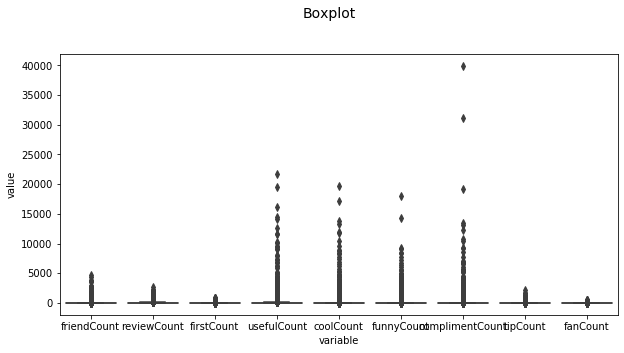

In [222]:
fig = plt.figure(figsize = (10,5))
title = fig.suptitle("Boxplot", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)
# a4_dims = (11.7, 8.27)
# df = mylib.load_data()
# fig, ax = pyplot.subplots(figsize=a4_dims)
ax1 = fig.add_subplot(1,1, 1)
sns.boxplot(x="variable", y="value", data=pd.melt(df_reviewer[['friendCount','reviewCount', 'firstCount', 'usefulCount',
                                                              'coolCount', 'funnyCount','complimentCount', 'tipCount', 'fanCount']]))

Either convert the features to categorical variables by binning them or use standard scaler.

In [255]:
def normalize(x):
    min_ = min(x)
    max_ = max(x)
    return [round((i - min_) / (max_ - min_), 2) for i in x]

In [260]:
df_reviewer['scaled_friendCount'] = normalize(df_reviewer['friendCount'])

In [263]:
df_reviewer.scaled_friendCount.describe()

count    14321.000000
mean         0.004460
std          0.025837
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: scaled_friendCount, dtype: float64